# Exercise project 3 (CNN time-series classification)
### Step 0: Importing libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### Step 1: Reading the dataset

For this project, I chose a digital currency dataset. The data represents historical daily time series for a digital currency (BTC) traded on the Saudi market.
Prices and volumes are quoted in both SAR & USD.
My two classes will be USD high and Volume. 


In [2]:
df = pd.read_csv("dc.csv")
df.head()

,date,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


Checking if the dataset has null values and using describe to see numerical columns.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1000 non-null   object 
 1   open_SAR   1000 non-null   float64
 2   open_USD   1000 non-null   float64
 3   high_SAR   1000 non-null   float64
 4   high_USD   1000 non-null   float64
 5   low_SAR    1000 non-null   float64
 6   low_USD    1000 non-null   float64
 7   close_SAR  1000 non-null   float64
 8   close_USD  1000 non-null   float64
 9   volume     1000 non-null   int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 78.3+ KB


In [4]:
df.describe()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,34825.322255,9285.762120,35789.618165,9542.880270,33796.329057,9011.393200,34917.483572,9310.335850,53100.498000
std,21728.028028,5793.522832,22785.946842,6075.604427,20565.410145,5483.524463,21928.280072,5846.917681,35329.832031
min,12045.197184,3211.710000,12288.185600,3276.500000,11837.237504,3156.260000,12045.234688,3211.720000,5743.000000
25%,24254.558752,6467.192500,24686.089152,6582.255000,23721.336256,6325.015000,24252.946080,6466.762500,30045.750000
50%,30714.632128,8189.695000,31321.953152,8351.630000,30010.869568,8002.045000,30713.263232,8189.330000,43795.500000
75%,38317.311744,10216.860000,39077.527200,10419.562500,37158.878816,9907.977500,38329.725568,10220.170000,64909.250000
max,152217.334784,40586.960000,157329.280000,41950.000000,145215.488000,38720.000000,152201.770624,40582.810000,402201.000000


### Step 2: Cleaning up the dataset, sequencing and scaling the data

Dropping the columns we won't be using.

In [5]:
df = df.drop(['open_SAR', 'open_USD', 'high_SAR', 'close_SAR', 'low_SAR', 'low_USD', 'close_USD'], axis=1)

Next, scaling the numeric columns with scikit-learn's MinMaxScaler().

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_cols = ['high_USD', 'volume']
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,date,high_USD,volume
0,2021-01-30,0.818558,0.094156
1,2021-01-29,0.911616,0.570260
2,2021-01-28,0.788847,0.219135
3,2021-01-27,0.757128,0.227434
4,2021-01-26,0.766555,0.199842


Converting the date column to sequencial, so our model can use it.

In [7]:
df['Sequence'] = df.index + 1
df = df.drop(['date'], axis=1)
df.head()

,high_USD,volume,Sequence
0,0.818558,0.094156,1
1,0.911616,0.570260,2
2,0.788847,0.219135,3
3,0.757128,0.227434,4
4,0.766555,0.199842,5


### Step 3: Timesteps
I generate sliding windows and, to form timesteps of size 40, I select every 40th window. Then, I vertically stack the windows into an array called X and construct the target array y, where 0 corresponds to Close values and 1 corresponds to Volume values

In [8]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 25

high = df['high_USD'].values
volume = df['volume'].values

high_windows = sliding_window_view(high, window_shape=timestep_size)[::timestep_size]
volume_windows = sliding_window_view(volume, window_shape=timestep_size)[::timestep_size]

X = np.vstack((high_windows, volume_windows))

# 0 = USD high
# 1 = Volume
y = np.array([0] * len(high_windows) + [1] * len(volume_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (80, 25)
y: (80,)


Next, I will randomly shuffle the data for good measures.

In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

The train and test is going to split at 75%. The first 75% will be the training, and the rest is for testing.

In [10]:
train_size = 0.75
splitter = int(len(X) * train_size)

x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

60
20
60
20


Next up, I will convert the data so it is CNN-compatible.

In [11]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_train

array([[[0.00986464],
        [0.01860473],
        [0.01888399],
        ...,
        [0.0218108 ],
        [0.01645132],
        [0.01039704]],

       [[0.81855793],
        [0.91161648],
        [0.78884714],
        ...,
        [1.        ],
        [0.95901586],
        [0.8704335 ]],

       [[0.16646489],
        [0.16684551],
        [0.16338035],
        ...,
        [0.23430851],
        [0.21362173],
        [0.21690563]],

       ...,

       [[0.12265505],
        [0.12045716],
        [0.12329244],
        ...,
        [0.12925104],
        [0.10812313],
        [0.12019859]],

       [[0.19058009],
        [0.09547796],
        [0.1346246 ],
        ...,
        [0.08257621],
        [0.07619723],
        [0.11260461]],

       [[0.10189478],
        [0.08947984],
        [0.13556039],
        ...,
        [0.06265985],
        [0.03400612],
        [0.03438952]]], shape=(60, 25, 1))

### Step 5: Creating the CNN model

In [12]:
class_names = np.array(['High', 'Volume'])
num_classes = len(class_names)
classes = [0, 1]
input_shape=x_train.shape[1:]

model = keras.Sequential(
    [
        keras.layers.Input(input_shape),

        keras.layers.Conv1D(filters=18, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),

        keras.layers.Dense(14, activation="relu"),

        keras.layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 18)         │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 18)         │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 25, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 18)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           266 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 36 (144.00 B)

### Step 6: Compiling model and fitting data
I compile the model and fit the now CNN-compatible data to the model.

In [13]:
epochs = 350
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/350
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.7524 - sparse_categorical_accuracy: 0.3958 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4167
Epoch 2/350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.7135 - sparse_categorical_accuracy: 0.4167 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.3333
Epoch 3/350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7088 - sparse_categorical_accuracy: 0.4792 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.3333
Epoch 4/350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.5625 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7074 - sparse_categorical_accuracy: 0.5625 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5833
Epoch 6/350
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6997 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5833
Epoch 7/350
2/2

#### Training loss:

<Axes: >

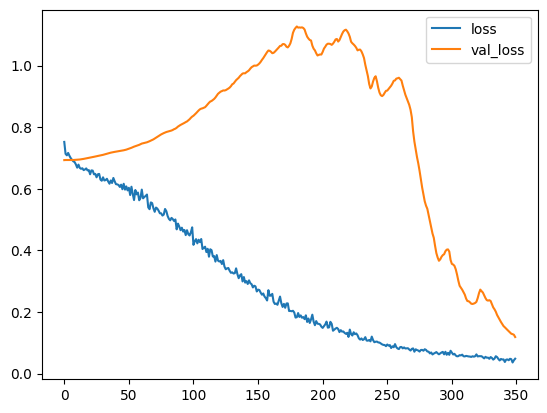

In [14]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

#### Training accuraccy:

<Axes: >

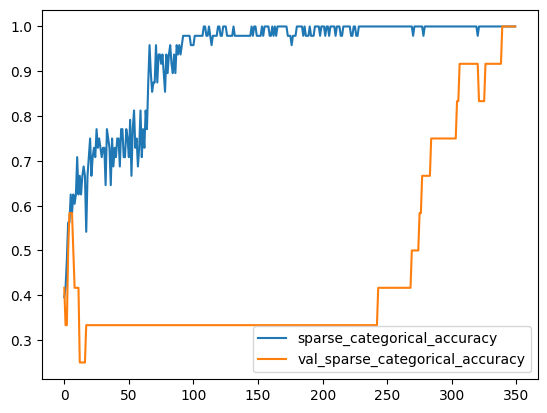

In [15]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

#### Train test and data evaluation

In [16]:
model = keras.models.load_model("best_model2.keras")

print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.11996026337146759, 0.949999988079071]

Train data evaluation:
[0.08172328025102615, 1.0]


### **Step 7:** Prediction and metrics
In this step, I predict the values with the model, and see how the accurate the model is.

In [17]:
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


#### Confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

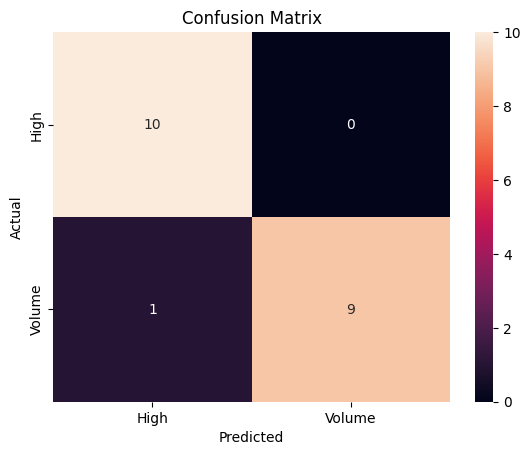

In [18]:
import seaborn as sns
cm = confusion_matrix(y_test, test_predictions)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

#### Classification report and overall accuracy:

In [19]:
print(classification_report(y_test, test_predictions, target_names=class_names))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

        High       0.91      1.00      0.95        10
      Volume       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


Model overall accuracy: 95.00%


As it seems the model can always predict if a value is High very accurately. However, Volumes were sometimes predicted to be Highs. It gives as an overall accuraccy of 70%.

#### ROC-AUC score
I have used AI's help to reshape the data to present the ROC-AUC score

In [20]:
# reshape X to include the channel dimension expected by the model
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# predict class probabilities
probs = model.predict(X_reshaped)

# compute ROC AUC
roc = roc_auc_score(y, probs[:, 1])
print("ROC AUC (ovr):", roc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
ROC AUC (ovr): 1.0


### Step 8: Imaginary values

I used AI once again to generate imaginary data.

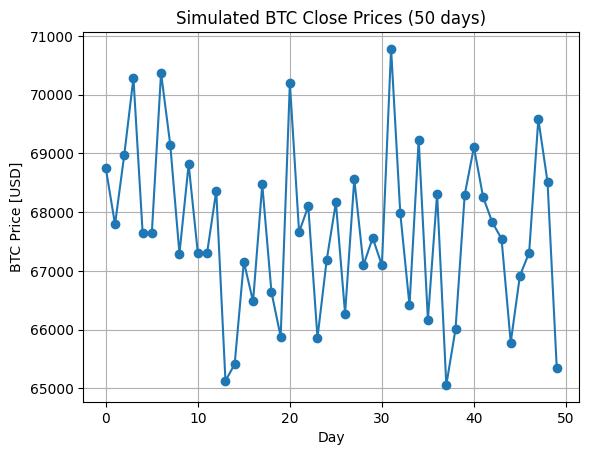

array([[0.00000000e+00, 6.87450712e+04],
       [1.00000000e+00, 6.77926035e+04],
       [2.00000000e+00, 6.89715328e+04],
       [3.00000000e+00, 7.02845448e+04],
       [4.00000000e+00, 6.76487699e+04]])

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# generate x values (days)
x = np.arange(0, 50)

# simulate BTC prices (close values)
np.random.seed(42)
y = np.random.normal(loc=68000, scale=1500, size=50)  # realistic USD values around 68k

# combine into array: each row = [day, price]
btc_data = np.column_stack((x, y))

# visualize
plt.plot(x, y, marker='o')
plt.title('Simulated BTC Close Prices (50 days)')
plt.xlabel('Day')
plt.ylabel('BTC Price [USD]')
plt.grid(True)
plt.show()

btc_data[:5]

And now I use the model to predict the class using the generated data.

In [22]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[1. 0.]]
High


## Conclusion

The results of this exercise were fairly mixed but straightforward at the end. I tried using too high timesteps at first, which was not working well with this little data. Using the prepared dataset, I managed to evaluate how well the model can distinguish between high_USD and volume values. While the accuracy was not miserable with high timesteps, the final model performed really well on the test data, showing that the classification between the two features can be learned.